## Table of Contents

- [Introduction](#intro)
- [Understanding the Data](#understand)
- [Problem Statement](#prob_statement)
- [Import Libraries and Helper Functions](#lib_func)
- [Data Cleaning](#cleaning)
- [Data Analysis](#analysis)
- [Data Modelling](#model)
- [Conclusion](#conclusion)
- [Version History](#version)

## <a id = "intro">Introduction</a>

While some rental companies have recently faced challenges and closures due to financial losses, such services are still essential in catering to the needs of commuters, tourists and cyclist enthusiasts. As an eco-friendly mode of transport, cycling promotes better health through active exercise, while also being an alternative to traditional methods of travel.y.

In this project, we will be analysing the dataset for bike rentals from Capital Bikeshare that records the number of rented bikes given the current day and weather in 2011 and 2012. Consisting of 17 features and 17379 records, the goal is to uncover rental trends and find ways to improve rental bike services.

Link: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

## <a id = "understand">Understanding the Data</a>

### Dataset Features

| Features | Details |
|---|---|
| instant | Recorded index |
| dteday | Recorded Date |
| season | Nominal category for the current season <br><br> 1: spring <br> 2: summer <br> 3: fall <br> 4: winter |
| yr | Boolean expression for the years 2011 and 2012 <br><br> 0: 2011 <br> 1: 2012 |
| mnth | Nominal category for months from 1 (Jan) to 12 (Dec) |
| hr | Ordinal category for hour from 0 (0th hour or 00:00) to 23 (23th hour or 23:00) |
| holiday | Boolean expression if a day is a holiday <br><br> 0: Non-holiday <br> 1: Holiday <br> For more info: http://dchr.dc.gov/page/holiday-schedule |
| weekday | Nominal category for days of the week from 0 (Sunday) to 6 (Saturday)|
| workingday | Boolean expression if a day is a working day <br><br> 0: if day is not a working day (either weekend or holiday) <br> 1: if day is a working day (neither weekend nor holiday) |
| weathersit | Nominal category for the current weather <br><br> 1: Clear, Few clouds, Partly cloudy, Partly cloudy <br> 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br> 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br> 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp | Normalized temperature in Celsius <br> Values are divided by 41 |
| atemp | Normalized apparent/feeling temperature in Celsius <br> Values are divided to 50 |
| hum | Normalized humidity <br> Values are divided to 100 |
| windspeed | Normalized wind speed <br> Values are divided to 67 |
| casual | Discrete numerical value for no. of casual users |
| registered | Discrete numerical value for no. of registered users |
| cnt | Discrete numerical value for both casual and registered users |

### Casual vs Registered Users

Mosty bike rental companies opt for phone applications as theirmainy platform for hosting their rental services.Within the application, users can rent bikes, pay rental fees, and optionally create an account..
Non-registered users are known as casual users. 

For casual users, the process is straightforward and hassle-free. They can simply hop on a bike without the need to create an account. However, their access to bike features is limited compared to registered users. Casual users may need to provide payment information upfront for all transactions

 On the other hand, registered users enjoy a more tailored experience. Registration is required but opens up a world of benefits, including access to loyalty programs, special discounts, and promotions. Like casual users, they may also need to provide payment information upfront for all transactions, but the perks and convenience make it worthwhile.

### Temperature vs Apparent Temperature

Measured with a thermometer, temperature reflects the actual, quantifiable heat of the environment. It's a concrete value, indicating the level of thermal energy present.

With apparent temperature, it is a more subjective realm of human perception. It considers various factors beyond the raw temperature reading, such as humidity and wind speed, to gauge how the weather feels to us. Essentially, it strives to capture the temperature experienced by the human body rather than the objective measurement of the surroundings. For instance, on a hot and humid day, the apparent temperature might register higher than the actual temperature, reflecting the added discomfort caused by factors like moisture in the air.

## <a id = "prob_statement">Problem Statement</a>

To understand how users are using the rental service, we want to know:

<ol>
    <li>Trends in Bike Rentals</li>
    <ul>
        <li>When are bikes being rented the most</li>
        <li>Does weather affect the number of rentals</li>
        <li>Is there a difference in trend for casual and registered users</li>
    </ul>
    <li>Improving Service</li>
    <ul>
        <li>Come up with business strategies or solutions to improve the number of bike rentals.</li>
    </ul>
</ol>

### Methodology Outline

<ol>
    <li>Data Cleaning</li>
    <ul>
        <li>Cleaning and checking for errors in the data</li>
        <li>Find if there are missing data</li>
    </ul>
    <li>Exploratory Data Analysis</li>
    <ul>
        <li>Analyse dataset and find conclusions to problem statement</li>
    </ul>
    <li>Data Modelling</li>
    <ul>
        <li>Fix missing data (datetimes) in the dataset using machine learning models</li>
    </ul>
</ol>

### <a id = "lib_func">Import Libraries and Helper Functions</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from collections import Counter
from datetime import datetime, timedelta

import math
import calendar

import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def IsDateValid(date):
    try:
        datetime.strptime(date, "%Y-%m-%d")
        return True
    except ValueError:
        return False

In [4]:
def IsWeekdayValid(date, weekday):
    if weekday == (datetime.strptime(date, "%Y-%m-%d").weekday() + 1) % 7:
        return True
    else:
        return False

In [5]:
def GetDateTime(date, hour):
    # Convert hour to %H:%M:%S
    time = f"{{:02d}}:00:00".format(hour)
    
    dt = datetime.strptime(f"{date} {time}", "%Y-%m-%d %H:%M:%S")
    return dt

In [6]:
def Plot_PieCategory(df, args = None):
    ax = plt.pie(df, labels = args["labels"] if "labels" in args else None, colors = args["colors"],
                 startangle = 90, counterclock = False,
                 autopct = lambda pct: f"{pct:.2f}%" if pct >= 10 else "")
    
    if args:
        if "title" in args:
            plt.title(args["title"])
        if "legend" in args and args["legend"]:
            plt.legend(labels = args["legend_labels"], loc = "upper left", bbox_to_anchor = (0.9, 1))
    
    return ax

In [7]:
def Plot_TimeSeries(df, mean_df, args = None):
    rows = df.shape[0]

    # Draw time series line plot\
    ax = sns.lineplot(df["casual"], label = "casual")
    sns.lineplot(df["registered"], label = "registered", ax = ax)
    sns.lineplot(df["count"], label = "count", ax = ax)

    # Draw mean line
    for user_type, user_mean in mean_df.items():
        if user_type == "casual":
            user_colour = "skyblue"
        elif user_type == "registered":
            user_colour = "moccasin"
        else:
            user_colour = "lightgreen"
            ax.text(0, user_mean + (user_mean * 0.025), "mean", color = "green")
            
        ax.plot([0, rows - 1], [user_mean, user_mean], linestyle = "--", color = user_colour)

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:,.0f}".format(x)))
    
    if args:
        if "title" in args:
            ax.set_title(args["title"])
        if "xlabel" in args:
            ax.set_xlabel(args["xlabel"])
        if "xticks" in args:
            ax.set_xticks(args["xticks"])
        if "xticklabels_color" in args:
            for tick_label, color in zip(ax.get_xticklabels(), args["xticklabels_color"]):
                tick_label.set_color(color)
        if "ylabel" in args:
            ax.set_ylabel(args["ylabel"])
        if "bbox_to_anchor" in args:
            ax.legend(bbox_to_anchor = args["bbox_to_anchor"])
    
    return ax

In [8]:
def centered_moving_average(data, window_size):
    half_window = int(window_size / 2)
    smoothed_data = []

    for i in range(len(data)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(data), i + half_window + 1)
        
        window = data[start_idx:end_idx]
        
        smoothed_value = sum(window) / len(window)
        smoothed_data.append(smoothed_value)
        
    return smoothed_data

In [9]:
def DayType(weekday, workingday, holiday):
    if holiday:
        return "Holiday"
    elif workingday:
        return "Working day"
    else:
        return "Weekend"

In [10]:
def Plot_Model_Result(y_pred, y_test, title):
    max_value = max(max(y_pred), max(y_test))

    plt.scatter(y_pred, y_test)
    plt.plot([0, max_value], [0, max_value], color = "red", label = "Identity Line")

    plt.title(title)
    plt.xlabel("Prediction Result")
    plt.ylabel("Actual Result")
    plt.legend()

    return plt

In [11]:
def Display_Calculated_Accuracy(y_pred, y_test):
    mse = mean_squared_error(y_pred, y_test)
    explained_var = 1 - mse / np.var(y_test)
    acc_perc = explained_var * 100

    print("Mean Squared Error: {:.6f}".format(mse))
    print("Accuracy (as percentage): {:.2f}%".format(acc_perc))

In [12]:
def PreProcessing_Missing_df(missing_df, cols):    
    season_df = pd.get_dummies(missing_df["season"]).rename(columns = {i + 1: col for i, col in enumerate(season_ohe_cols)})

    year_df = pd.get_dummies(missing_df["year"]).rename(columns = {col: f"is_{col}" for col in missing_df["year"].unique()})

    month_df = pd.get_dummies(missing_df["month"]).rename(columns = {i + 1: col for i, col in enumerate(month_ohe_cols)})

    day_type_df = missing_df.apply(lambda x: DayType(x["weekday"], x["working day"], x["holiday"]), axis = 1)
    day_type_df = pd.get_dummies(day_type_df).rename(columns = {col: f"is_{col}" for col in day_type_df.unique()})

    weather_df = pd.get_dummies(missing_df["weather"]).rename(columns = {i + 1: col for i, col in enumerate(weather_ohe_cols)})
    
    hour_df = missing_df["hour"].astype(int)
    temp_df = missing_df["temp"] * 41
    humidity_df = missing_df["humidity"] * 100
    wind_speed_df = missing_df["wind speed"] * 67

    df = pd.concat([season_df, year_df, month_df, day_type_df, weather_df, hour_df, temp_df, humidity_df, wind_speed_df], axis = 1)

    # Include missing columns that are not seen when doing one hot encoding with a small df
    for col in set(cols) - set(df.columns):
        df[col] = False

    # Reorder columns
    df = df[cols]
    
    return df

In [13]:
df = pd.read_csv("hour.csv")

In [14]:
df.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

### <a id = "cleaning">Data Cleaning</a>

### Clean Dataset and check for errors

#### Remove redundant columns

`instant` is not needed as dataframes have their own way of indexing

In [15]:
df = df.drop(["instant"], axis = 1)

#### Rename and reorder columns

Renaming to their full name and reordering columns, for personal preference

In [16]:
df = df.rename(columns = {"dteday": "date", "yr": "year", "mnth": "month", "hr": "hour", "workingday": "working day", "weathersit": "weather", "hum": "humidity", "windspeed": "wind speed", "cnt": "count"})

column_order = ["date", "season", "year", "month", "hour", "weekday", "working day", "holiday", "weather", "temp", "atemp", "humidity", "wind speed", "casual", "registered", "count"]
df = df[column_order]

In [17]:
df.head()

date  season  year  month  hour  weekday  working day  holiday  \
0  2011-01-01       1     0      1     0        6            0        0   
1  2011-01-01       1     0      1     1        6            0        0   
2  2011-01-01       1     0      1     2        6            0        0   
3  2011-01-01       1     0      1     3        6            0        0   
4  2011-01-01       1     0      1     4        6            0        0   

   weather  temp   atemp  humidity  wind speed  casual  registered  count  
0        1  0.24  0.2879      0.81         0.0       3          13     16  
1        1  0.22  0.2727      0.80         0.0       8          32     40  
2        1  0.22  0.2727      0.80         0.0       5          27     32  
3        1  0.24  0.2879      0.75         0.0       3          10     13  
4        1  0.24  0.2879      0.75         0.0       0           1      1

#### Check if any features are missing

In [18]:
assert(not any(list(df.isna().any())))
print(df.isna().any())

date           False
season         False
year           False
month          False
hour           False
weekday        False
working day    False
holiday        False
weather        False
temp           False
atemp          False
humidity       False
wind speed     False
casual         False
registered     False
count          False
dtype: bool


No features have missing values

#### Check if any value errors with data type

In [19]:
df.dtypes

date            object
season           int64
year             int64
month            int64
hour             int64
weekday          int64
working day      int64
holiday          int64
weather          int64
temp           float64
atemp          float64
humidity       float64
wind speed     float64
casual           int64
registered       int64
count            int64
dtype: object

- All features that are an `integers` are correctly assigned, whether it is assigned as a number category or a discrete value
- `temp`, `atemp`, `hum` and `wind speed` are all in decimal numbers (Correct because of normalisation)
- As numbers can be seen as `object` if the column contains any form of `string`, `date` will need to be checked using date validation

#### Check for any season errors

season should be a number 1) spring, 2) summer, 3) fall, and 4) winter

In [20]:
season_unique = list(sorted(df["season"].unique()))
assert(season_unique == [1, 2, 3, 4])
print(f"Seasons: {season_unique}")

Seasons: [1, 2, 3, 4]


Check if for every date, there is one

In [21]:
len(df["date"].unique())

731

#### Check for any weekday errors

weekday should be a number from 0 (Sunday) to 6 (Saturday)

In [22]:
weekday_unique = list(sorted(df["weekday"].unique()))
assert(weekday_unique == [0, 1, 2, 3, 4, 5, 6])
print(f"Weekdays: {weekday_unique}")

Weekdays: [0, 1, 2, 3, 4, 5, 6]


#### Check for any working day errors

Days that are working days should not be a holiday or a weekend
- holiday should be 0
- weekday should be a number from 1 (Monday) to 5 (Friday)

In [23]:
workingday_unique = list(sorted(df["working day"].unique()))
assert(workingday_unique == [0, 1])
print(f"Working days: {workingday_unique}")

Working days: [0, 1]


In [24]:
workingday_holiday = list(sorted(df.loc[df["working day"] == 1, "holiday"].unique()))
assert(workingday_holiday == [0])
print(f"Holidays on a working day: {workingday_holiday}")

workingday_weekday = list(sorted(df.loc[df["working day"] == 1, "weekday"].unique()))
assert(workingday_weekday == [1, 2, 3, 4, 5])
print(f"Weekdays on a working day: {workingday_weekday}")

Holidays on a working day: [0]
Weekdays on a working day: [1, 2, 3, 4, 5]


#### Check for any holiday errors

holiday should be a number 0 (non-holiday) or 1 (holiday)

In [25]:
holiday_unique = list(sorted(df["holiday"].unique()))
assert(holiday_unique == [0, 1])
print(f"Holidays: {holiday_unique}")

Holidays: [0, 1]


#### Check for any weather errors

weather should be categorised numerically from 1 to 4

In [26]:
weather_unique = list(sorted(df["weather"].unique()))
assert(weather_unique == [1, 2, 3, 4])
print(f"Weathers: {weather_unique}")

Weathers: [1, 2, 3, 4]


#### Check for any casual, registered, count errors

count is the sum of casual and registered

In [27]:
assert(list(df["casual"] + df["registered"] == df["count"]))

print(list(df["casual"].head()))
print(list(df["registered"].head()))
print(list(df["count"].head()))

[3, 8, 5, 3, 0]
[13, 32, 27, 10, 1]
[16, 40, 32, 13, 1]


#### Check for any date/time errors

##### year

- 0 for 2011 and 1 for 2012

In [28]:
date_year = sorted(set((year, date) for year, date in zip(list(df["year"]), [date.split("-")[0] for date in df["date"]])))

In [29]:
print(f"They are: {date_year}")

They are: [(0, '2011'), (1, '2012')]


##### month

month should be the same month seen in date

In [30]:
date_month = sorted(set((month, date) for month, date in zip(list(df["month"]), [date.split("-")[1] for date in df["date"]])))

In [31]:
print(f"They are: {date_month}")

They are: [(1, '01'), (2, '02'), (3, '03'), (4, '04'), (5, '05'), (6, '06'), (7, '07'), (8, '08'), (9, '09'), (10, '10'), (11, '11'), (12, '12')]


##### hour

there should only be hours from 0 to 23

In [32]:
hour_unique = list(sorted(df["hour"].unique()))
assert(hour_unique == list(range(0, 24)))
print(f"Hours: {hour_unique}")

Hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


##### date

As we need to compare the date with the weekday using datetime.datetime, we should first check if the date is a valid date

In [33]:
# Checks if all dates are valid
assert(all(list(df["date"].apply(lambda x: IsDateValid(x)))) == True)
print("All dates are valid")

All dates are valid


##### weekday

After confirming that all dates in the column are valid, we can check if the date matches the correct weekday

In [34]:
# Checks if all weekdays are valid
assert(all(list(df[["date", "weekday"]].apply(lambda x: IsWeekdayValid(x["date"], x["weekday"]), axis = 1))))
print("All weekdays are valid")

All weekdays are valid


##### Check for missing date/time

Check if there is any missing datetime as a day should have 24 hours of recorded data

In [35]:
df["datetime"] = df[["date", "hour"]].apply(lambda x: GetDateTime(x["date"], x["hour"]), axis = 1)

# Reorder columns
column_order.insert(0, "datetime")
df = df[column_order]

df.head()

datetime        date  season  year  month  hour  weekday  \
0 2011-01-01 00:00:00  2011-01-01       1     0      1     0        6   
1 2011-01-01 01:00:00  2011-01-01       1     0      1     1        6   
2 2011-01-01 02:00:00  2011-01-01       1     0      1     2        6   
3 2011-01-01 03:00:00  2011-01-01       1     0      1     3        6   
4 2011-01-01 04:00:00  2011-01-01       1     0      1     4        6   

   working day  holiday  weather  temp   atemp  humidity  wind speed  casual  \
0            0        0        1  0.24  0.2879      0.81         0.0       3   
1            0        0        1  0.22  0.2727      0.80         0.0       8   
2            0        0        1  0.22  0.2727      0.80         0.0       5   
3            0        0        1  0.24  0.2879      0.75         0.0       3   
4            0        0        1  0.24  0.2879      0.75         0.0       0   

   registered  count  
0          13     16  
1          32     40  
2          27     32  
3          10     13  
4           1      1

In [36]:
prev_dt = None

before_after_dt = []
missing_dt = []

for curr_dt in df["datetime"]:    
    if prev_dt == None:
        prev_dt = curr_dt
        continue

    hour_difference = int((curr_dt - prev_dt).seconds / 3600)
    
    # No need to check if curr_dt is before prev_dt as they are sorted in order
    if hour_difference != 1:        
        for missing_hour in range(hour_difference - 1):
            missing_dt.append(prev_dt + timedelta(hours = 1 + missing_hour))
        before_after_dt.append(
            {
                "prev_dt": prev_dt,
                "next_dt": curr_dt,
                "hour_difference": hour_difference
            }
        )
    
    prev_dt = curr_dt

In [37]:
# count the number of dates appearing and sort them by number of occurences
missing_dt_times = sorted(Counter([dt.date() for dt in missing_dt]).items(), reverse = True, key = lambda x: x[1])
missing_dt_times[:5]

[(datetime.date(2011, 1, 27), 16),
 (datetime.date(2011, 1, 18), 12),
 (datetime.date(2012, 10, 29), 12),
 (datetime.date(2011, 1, 26), 8),
 (datetime.date(2011, 8, 28), 7)]

In [38]:
print(f"There are {len(missing_dt)} missing datetimes")

There are 141 missing datetimes


We have identified 141 missing datetimes in the dataset.

In this project, we will isolate annd fill in these missing datetime records with the following below:
- Features related to dates will be populated based on existing data.
    - We know that all days are least seen once in df, since there are no missing datetimes occuring 24 times (one day has 24 hours). Therefore, we can identify the corresponding season or type of day by examining similar dates present in the dataset
- We will use interpolation for features related to weather (`weather`, `temp`, `atemp`, `humidity`, `wind speed`)
    - Interpolation estimates and fills in missing values based on nearby known datetime records.
- Finally, we will train machine learning models to predict the values of `casual` and `registered` users based on the datetime and weather patterns.
    - This would ultimately sum up to fill in `count`

In [39]:
prev_dt_index = df[df["datetime"] == before_after_dt[0]["prev_dt"]].index[0]
next_dt_index = df[df["datetime"] == before_after_dt[0]["next_dt"]].index[0]

test_df = df.loc[prev_dt_index:next_dt_index, ["weather", "temp", "atemp", "humidity", "wind speed"]]

test_to_add = 4

interpolate_dict = {
    "weather": np.around(np.linspace(test_df.loc[prev_dt_index, "weather"],
                                     test_df.loc[next_dt_index, "weather"],
                                     num = test_to_add)[1: -1]).astype(int),
    "temp": np.around(np.linspace(test_df.loc[prev_dt_index, "temp"],
                                  test_df.loc[next_dt_index, "temp"],
                                  num = test_to_add)[1: -1], 2),
    "atemp": np.around(np.linspace(test_df.loc[prev_dt_index, "atemp"],
                                   test_df.loc[next_dt_index, "atemp"],
                                   num = test_to_add)[1: -1], 4),
    "humidity": np.around(np.linspace(test_df.loc[prev_dt_index, "humidity"],
                                      test_df.loc[next_dt_index, "humidity"],
                                      num = test_to_add)[1: -1], 2),
    "wind speed": np.around(np.linspace(test_df.loc[prev_dt_index, "wind speed"],
                                        test_df.loc[next_dt_index, "wind speed"],
                                        num = test_to_add)[1: -1], 4),
}

# See interpolation results
interpolate_dict

{'weather': array([2, 3]),
 'temp': array([0.45, 0.43]),
 'atemp': array([0.4444, 0.4343]),
 'humidity': array([0.88, 0.83]),
 'wind speed': array([0.2288, 0.2637])}

In [40]:
np.around(np.linspace(test_df.loc[prev_dt_index, "temp"],
            test_df.loc[next_dt_index, "temp"],
            num = test_to_add), 2)

array([0.46, 0.45, 0.43, 0.42])

In [41]:
missing_df = pd.DataFrame(columns = df.columns)

for dt_info in before_after_dt:
    prev_dt = dt_info["prev_dt"]
    next_dt = dt_info["next_dt"]
    dt_to_add = dt_info["hour_difference"] - 1

    prev_index = df[df["datetime"] == prev_dt].index[0]
    next_index = prev_index + 1
    weather_df = df.loc[prev_index:next_index, ["weather", "temp", "atemp", "humidity", "wind speed"]]

    interpolate_dict = {
        "weather": np.around(np.linspace(weather_df.loc[prev_index, "weather"],
                                         weather_df.loc[next_index, "weather"],
                                         num = dt_to_add + 2)[1: -1]).astype(int),
        "temp": np.around(np.linspace(weather_df.loc[prev_index, "temp"],
                                      weather_df.loc[next_index, "temp"],
                                      num = dt_to_add + 2)[1: -1], 2),
        "atemp": np.around(np.linspace(weather_df.loc[prev_index, "atemp"],
                                       weather_df.loc[next_index, "atemp"],
                                       num = dt_to_add + 2)[1: -1], 4),
        "humidity": np.around(np.linspace(weather_df.loc[prev_index, "humidity"],
                                          weather_df.loc[next_index, "humidity"],
                                          num = dt_to_add + 2)[1: -1], 2),
        "wind speed": np.around(np.linspace(weather_df.loc[prev_index, "wind speed"],
                                            weather_df.loc[next_index, "wind speed"],
                                            num = dt_to_add + 2)[1: -1], 4),
    }

    for i in range(dt_to_add):
        dt = prev_dt + timedelta(hours = 1 + i)
        time_periods_df = df.loc[df["date"] == dt.date().strftime("%Y-%m-%d"), ["season", "working day", "holiday"]]
        
        new_row = pd.DataFrame({
            "datetime": dt,
            "date": dt.date(),
            "season": time_periods_df["season"].values[0],
            "year": dt.year,
            "month": dt.month,
            "hour": dt.hour,
            "weekday": (dt.weekday() + 1) % 7,
            "working day": time_periods_df["working day"].values[0],
            "holiday": time_periods_df["holiday"].values[0],
            "weather": interpolate_dict["weather"][i],
            "temp": interpolate_dict["temp"][i],
            "atemp": interpolate_dict["atemp"][i],
            "humidity": interpolate_dict["humidity"][i],
            "wind speed": interpolate_dict["wind speed"][i],
            "casual": np.nan,
            "registered": np.nan,
            "count": np.nan,
        }, index = [0])

        missing_df = pd.concat([missing_df, new_row]).reset_index(drop = True)

In [42]:
missing_df.head()

datetime        date season  year month hour weekday working day  \
0 2011-01-02 05:00:00  2011-01-02      1  2011     1    5       0           0   
1 2011-01-03 02:00:00  2011-01-03      1  2011     1    2       1           1   
2 2011-01-03 03:00:00  2011-01-03      1  2011     1    3       1           1   
3 2011-01-04 03:00:00  2011-01-04      1  2011     1    3       2           1   
4 2011-01-05 03:00:00  2011-01-05      1  2011     1    3       3           1   

  holiday weather  temp   atemp  humidity  wind speed  casual  registered  \
0       0       2  0.44  0.4394      0.86      0.2462     NaN         NaN   
1       0       1  0.19  0.1566      0.45      0.4080     NaN         NaN   
2       0       1  0.17  0.1465      0.46      0.3980     NaN         NaN   
3       0       1  0.14  0.1666      0.63      0.1120     NaN         NaN   
4       0       1  0.20  0.2122      0.61      0.1568     NaN         NaN   

   count  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN

The missing values in these dates will be addressed later by predicting the casual and registered values with the help of modelling.

### <a id = "analysis">Data Analysis</a>

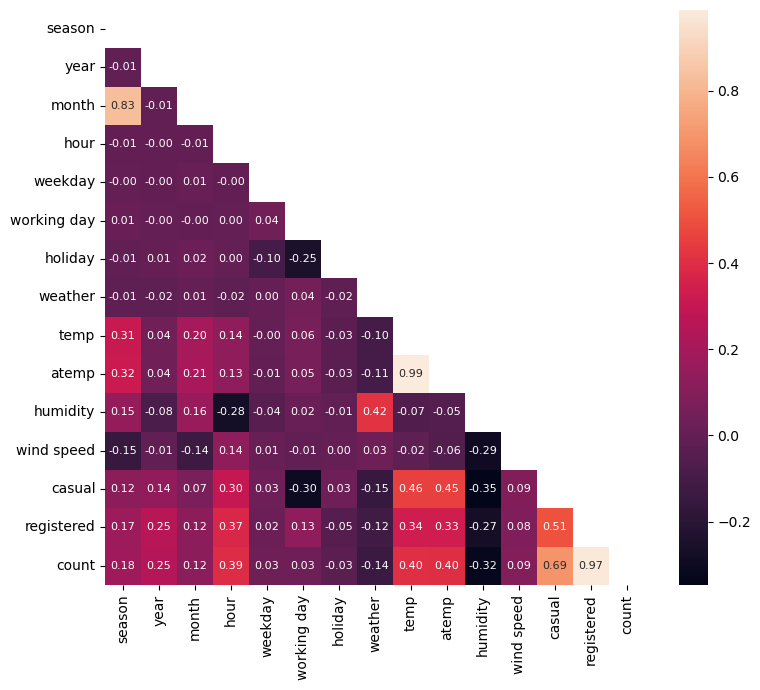

In [43]:
heatmap_corr = df[["season", "year", "month", "hour", "weekday", "working day", "holiday", "weather", "temp", "atemp", "humidity", "wind speed", "casual", "registered", "count"]].corr()

plt.figure(figsize = (8, 7))
sns.heatmap(heatmap_corr, mask = np.triu(heatmap_corr), annot = True, fmt = ".2f", annot_kws = {"fontsize": 8})

plt.tight_layout()
plt.show()

<ol>
    <li>Casual and Registered users do not have a similar pattern. </li>
    <ul>
        <li>Working day</li>
        Casual has a negative correlation while Registered has a positive correlation
        <li>Weather features</li>
        Casual has a higher correlation than Registered
    </ul>
    <li>temp and atemp are highly correlated</li>
    They may cause multicollinearity issues when modelling
    <li>Weather features like temperature and humidity seem to have the most affect on Casual and Registered users</li>
</ol>

#### Mapping categories and Unnormalising weather values

To have a better visualisation, we will be mapping categorical values and unnormalising weather values.

In [44]:
mapped_df = df.copy()

season_order = ["Spring", "Summer", "Fall", "Winter"]
season_map = {i + 1: season for i, season in enumerate(season_order)}
mapped_df["season"] = mapped_df["season"].map(season_map)

year_order = ["2011", "2012"]
year_map = {i: year for i, year in enumerate(year_order)}
mapped_df["year"] = mapped_df["year"].map(year_map)

month_order = calendar.month_abbr[1:]
month_map = {i + 1: month for i, month in enumerate(month_order)}
mapped_df["month"] = mapped_df["month"].map(month_map)

weekday_order = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
weekday_map = {i: day for i, day in enumerate(weekday_order)}
mapped_df["weekday"] = mapped_df["weekday"].map(weekday_map)

true_false_map = {0: False, 1: True}
mapped_df["working day"] = mapped_df["working day"].map(true_false_map)
mapped_df["holiday"] = mapped_df["holiday"].map(true_false_map)

weather_order = ["Clear and cloudy", "Misty with varying clouds", "Light precipitation and thunder", "Intense storm with mixed precipitation"]
weather_map = {i + 1: weather for i, weather in enumerate(weather_order)}
mapped_df["weather"] = mapped_df["weather"].map(weather_map)

In [45]:
mapped_df["temp"] = mapped_df["temp"] * 41
mapped_df["atemp"] = mapped_df["atemp"] * 50
mapped_df["humidity"] = mapped_df["humidity"] * 100
mapped_df["wind speed"] = mapped_df["wind speed"] * 67

In [46]:
mapped_df.head()

datetime        date  season  year month  hour weekday  \
0 2011-01-01 00:00:00  2011-01-01  Spring  2011   Jan     0     Sat   
1 2011-01-01 01:00:00  2011-01-01  Spring  2011   Jan     1     Sat   
2 2011-01-01 02:00:00  2011-01-01  Spring  2011   Jan     2     Sat   
3 2011-01-01 03:00:00  2011-01-01  Spring  2011   Jan     3     Sat   
4 2011-01-01 04:00:00  2011-01-01  Spring  2011   Jan     4     Sat   

   working day  holiday           weather  temp   atemp  humidity  wind speed  \
0        False    False  Clear and cloudy  9.84  14.395      81.0         0.0   
1        False    False  Clear and cloudy  9.02  13.635      80.0         0.0   
2        False    False  Clear and cloudy  9.02  13.635      80.0         0.0   
3        False    False  Clear and cloudy  9.84  14.395      75.0         0.0   
4        False    False  Clear and cloudy  9.84  14.395      75.0         0.0   

   casual  registered  count  
0       3          13     16  
1       8          32     40  
2       5          27     32  
3       3          10     13  
4       0           1      1

#### User Count

Analysing user growth over the 2 years

In [47]:
user_count_df = mapped_df.groupby("year").agg({"casual": "sum", "registered": "sum"})
user_count_perc_df = user_count_df.div(user_count_df.sum(axis = 1), axis = 0).round(4) * 100 

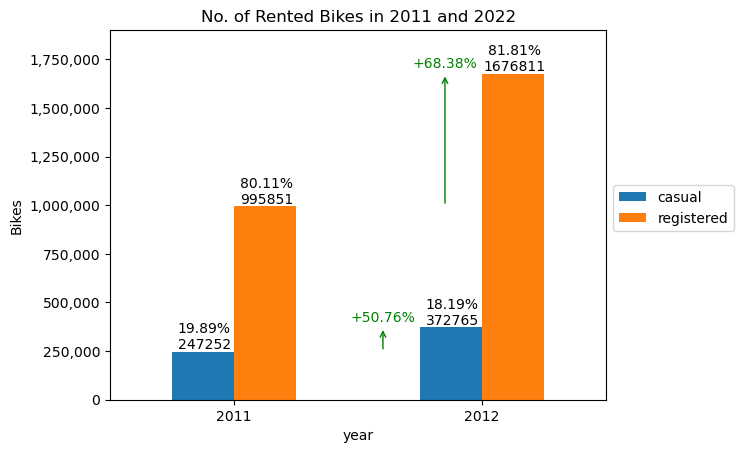

In [48]:
user_count_df.plot(kind = "bar", rot = 0)

casual_values = user_count_df["casual"].values
casual_perc = user_count_perc_df["casual"].values

registered_values = user_count_df["registered"].values
registered_perc = user_count_perc_df["registered"].values

for i, count in enumerate(casual_values):
    plt.text(i - 0.12, count + 75000, f"{casual_perc[i]}%\n{count}", ha = "center", va = "center")

plt.annotate("+{:.2f}%".format((casual_values[1] - casual_values[0]) / casual_values[0] * 100), 
             xy = (1 - 0.4, casual_values[0]), xytext = (1 - 0.4, casual_values[1] + 50000), 
             arrowprops = dict(color = "green", arrowstyle = "<-"), 
             ha = "center", va = "center", color = "green", fontweight = "light")

for i, count in enumerate(registered_values):
    plt.text(i + 0.13, count + 75000, f"{registered_perc[i]}%\n{count}", ha = "center", va = "center")

plt.annotate("+{:.2f}%".format((registered_values[1] - registered_values[0]) / registered_values[0] * 100), 
             xy = (1 - 0.15, registered_values[0]), xytext = (1 - 0.15, registered_values[1] + 50000), 
             arrowprops = dict(color = "green", arrowstyle = "<-"), 
             ha = "center", va = "center", color = "green", fontweight = "light")

plt.ylabel("Bikes")
plt.ylim([0, 1900000])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:,.0f}".format(x)))

plt.title("No. of Rented Bikes in 2011 and 2022")
plt.legend(bbox_to_anchor = (1, 0.6))

plt.show()

From the yearly data in 2011 and 2022
- Most rental rides are registered (~80%), with a rise of 1.7% (from 80.11% -> 81.81%) registered rental rides
- The number of rides increased by more than 50% for both casual (+50.76%) and registered (+68.38%)

#### Season and Monthly rentals

Analysing the number of rentals by season

In [49]:
season_rental_df = mapped_df.groupby(["season"]).agg(casual = ("casual", "sum"), registered = ("registered", "sum"), count = ("count", "sum")).reindex(season_order)
month_total_df = mapped_df.groupby("month").agg({"casual": "sum", "registered": "sum", "count": "sum"}).reindex(month_order)
month_mean_df = mapped_df.groupby("month").agg({"casual": "mean", "registered": "mean", "count": "mean"}).reindex(month_order)

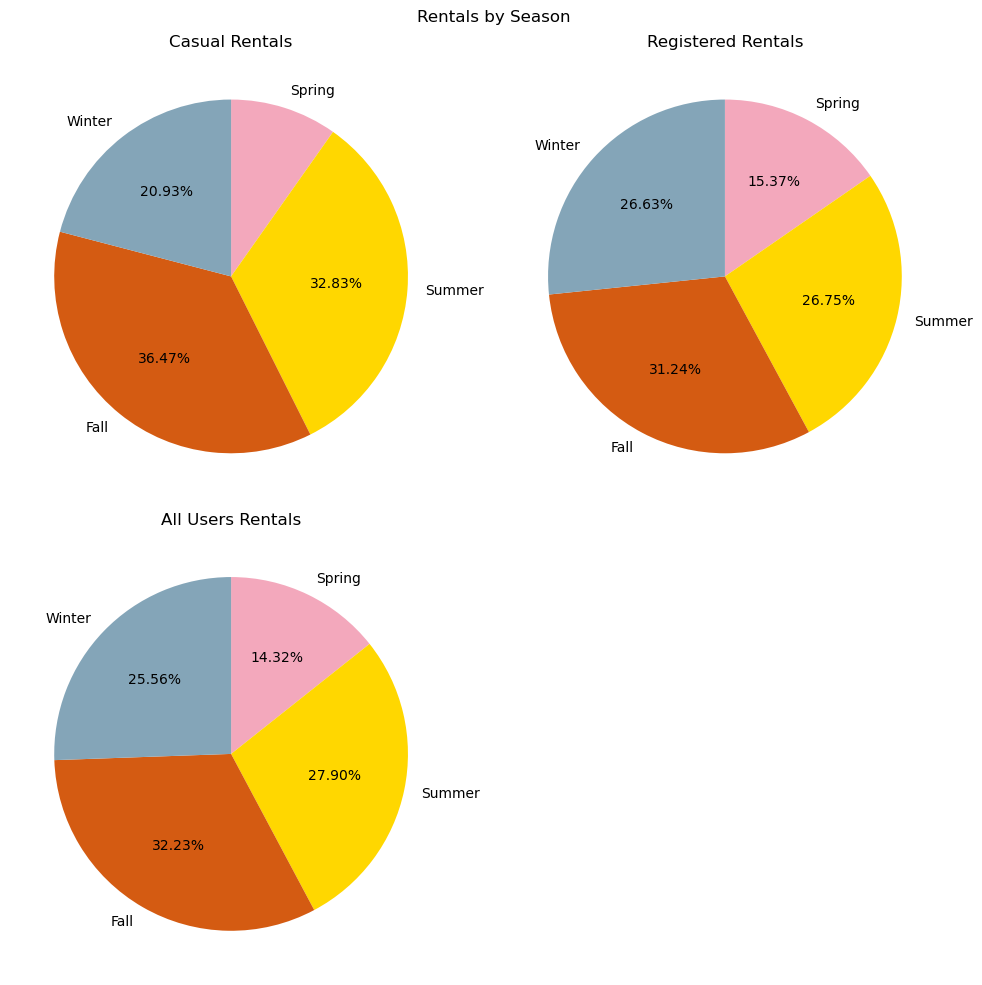

In [50]:
season_colours = ["#F3A8BC", "#FFD700", "#D45B12", "#84A5B8"]

fig, axList = plt.subplots(2, 2, figsize = (10, 10))
axList = axList.flatten()
axList[len(axList) - 1].set_visible(False)

plt.suptitle("Rentals by Season")

plt.subplot(2, 2, 1)
Plot_PieCategory(season_rental_df["casual"], args = {
    "labels": season_order,
    "colors": season_colours,
    "title": "Casual Rentals"
})

plt.subplot(2, 2, 2)
Plot_PieCategory(season_rental_df["registered"], args = {
    "labels": season_order,
    "colors": season_colours,
    "title": "Registered Rentals"
})

plt.subplot(2, 2, 3)
Plot_PieCategory(season_rental_df["count"], args = {
    "labels": season_order,
    "colors": season_colours,
    "title": "All Users Rentals"
})

plt.tight_layout()
plt.show()

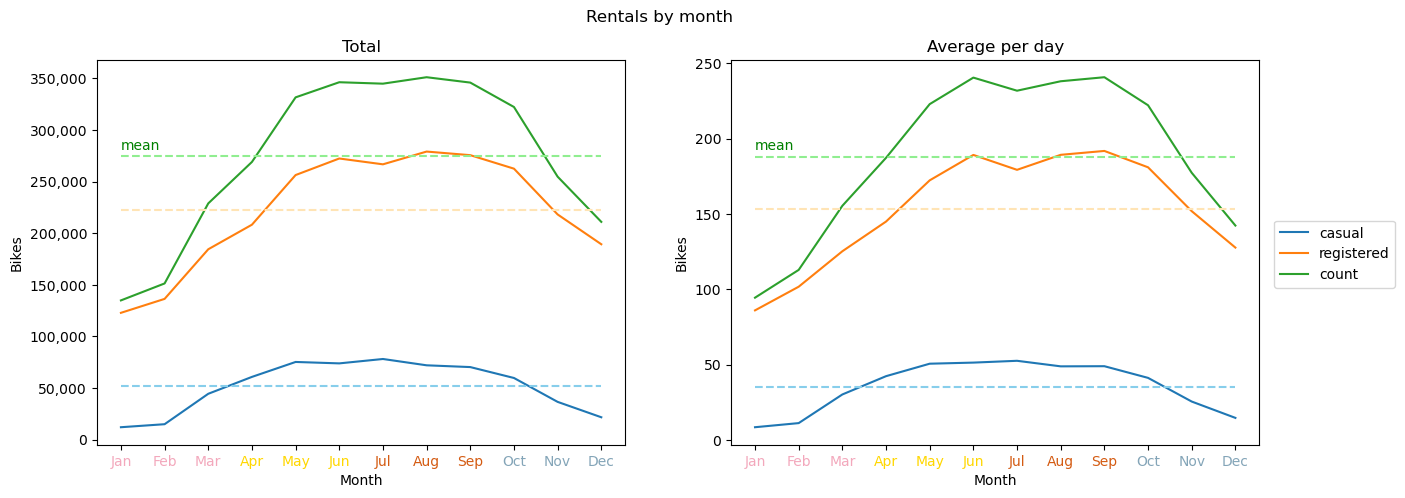

In [51]:
plt.subplots(1, 2, figsize = (15, 5))
plt.suptitle("Rentals by month")

plt.subplot(1, 2, 1)
ax = Plot_TimeSeries(month_total_df, month_total_df.mean().astype(int), args = {
    "title": "Total",
    "xlabel": "Month",
    "xticklabels_color": np.repeat(season_colours, 3), # Used to colourcode xlabels, similar to pie graph
    "ylabel": "Bikes",
    "bbox_to_anchor": (1.27, 0.6)
})

ax.get_legend().remove()

plt.subplot(1, 2, 2)
Plot_TimeSeries(month_mean_df, month_mean_df.mean().astype(int), args = {
    "title": "Average per day",
    "xlabel": "Month",
    "xticklabels_color": np.repeat(season_colours, 3),
    "ylabel": "Bikes",
    "bbox_to_anchor": (1.27, 0.6)
})

# plt.tight_layout()
plt.show()

Based on the different seasons and months in the years
- Most bikes are rented during Summer and Fall, in the middle of the year
- Spring has the least number of bikes rented
- There are more casual rentals during summer than registered rentals

#### Hourly rentals

Analysing the number of rentals by the hour

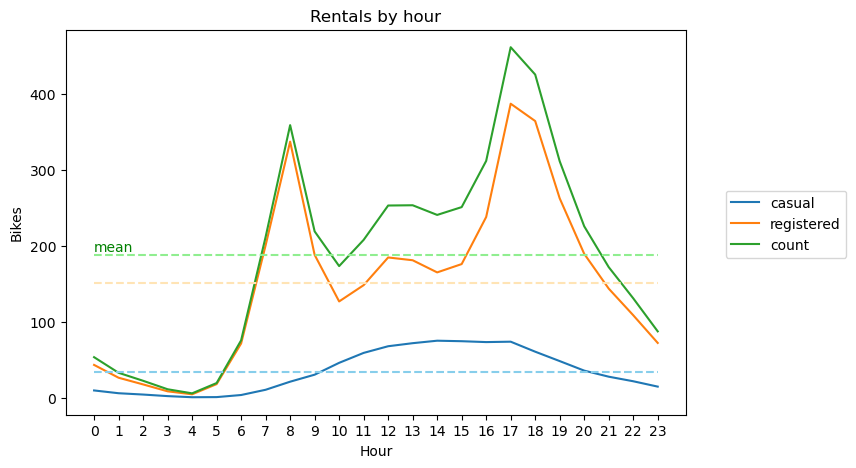

In [52]:
hour_df = mapped_df.groupby("hour").agg({"casual": "mean", "registered": "mean", "count": "mean"}).reindex(range(0, 24))

plt.figure(figsize = (8, 5))
Plot_TimeSeries(hour_df, hour_df.mean().astype(int), args = {
    "title": "Rentals by hour",
    "xlabel": "Hour",
    "xticks": list(range(0, 24)),
    "ylabel": "Bikes",
    "bbox_to_anchor": (1.27, 0.6)
})

plt.show()

Based on the different hours in a day
- Registered users generally rent bikes during peak hours (morning peak and evening peak)
- Casual users generally rent bike as the during afternoon

#### Day rentals

Analysing the number of rentals by the hour in different days (weekdays and weekends)

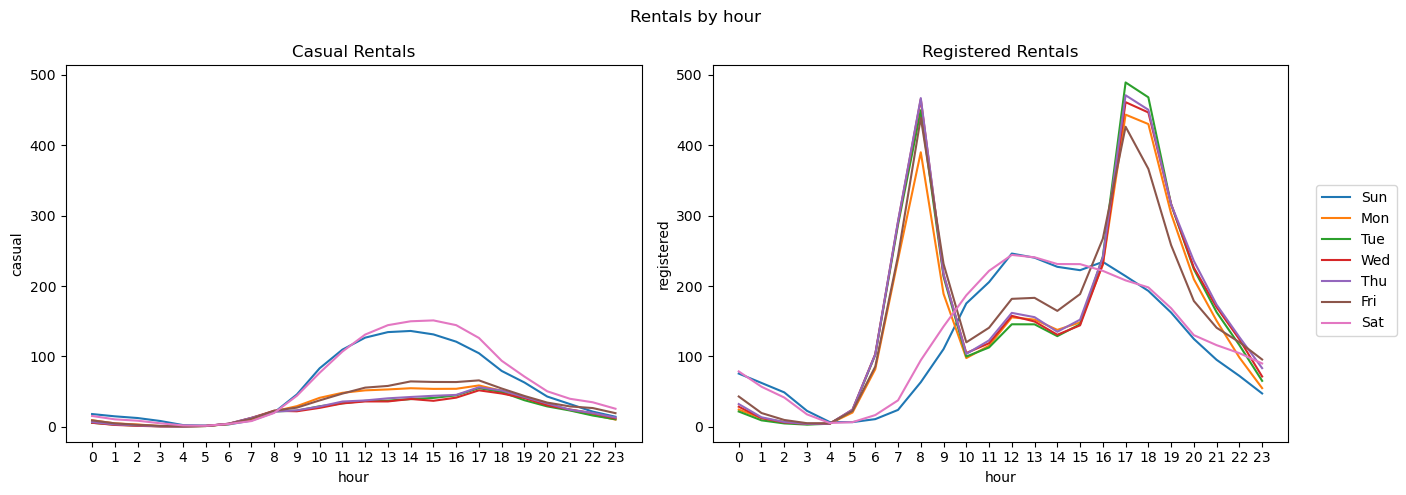

In [53]:
weekday_df = mapped_df.groupby(["weekday", "hour"]).agg({"casual": "mean", "registered": "mean"}).reset_index().sort_values(by = "weekday", key = lambda x: x.map({weekday: i for i, weekday in enumerate(weekday_order)}))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 5))
fig.suptitle("Rentals by hour")

sns.lineplot(weekday_df, x = "hour", y = "casual", hue = "weekday", ax = ax0)
sns.lineplot(weekday_df, x = "hour", y = "registered", hue = "weekday", ax = ax1)

ax0.set_title("Casual Rentals")
ax1.set_title("Registered Rentals")

ax0.get_legend().remove()

x_lim = (min(ax0.get_xlim()[0], ax1.get_xlim()[0]), max(ax0.get_xlim()[1], ax1.get_xlim()[1]))
y_lim = (min(ax0.get_ylim()[0], ax1.get_ylim()[0]), max(ax0.get_ylim()[1], ax1.get_ylim()[1]))

ax0.set_xlim(x_lim)
ax0.set_ylim(y_lim)
ax0.set_xticks(list(range(0, 24)))

ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)
ax1.set_xticks(list(range(0, 24)))

ax1.legend(loc = "upper right", bbox_to_anchor = (1.2, 0.7))

plt.tight_layout()
plt.show()

Based on the different hours of different days (weekdays and weekends)
- Registered users generally rent bikes during peak hours (morning peak and evening peak)
- Casual users generally rent bike as the during afternoon

#### Day Type rentals

Analysing the number of rentals by the hour in different days (working day, weekend or holiday)

A weekday is typically a working day, but can be a public holiday too. Would there be different trends for the 3 different day types?

In [54]:
mapped_df["day type"] = mapped_df.apply(lambda x: DayType(x["weekday"], x["working day"], x["holiday"]), axis = 1)
day_types = ["Working day", "Weekend", "Holiday"]

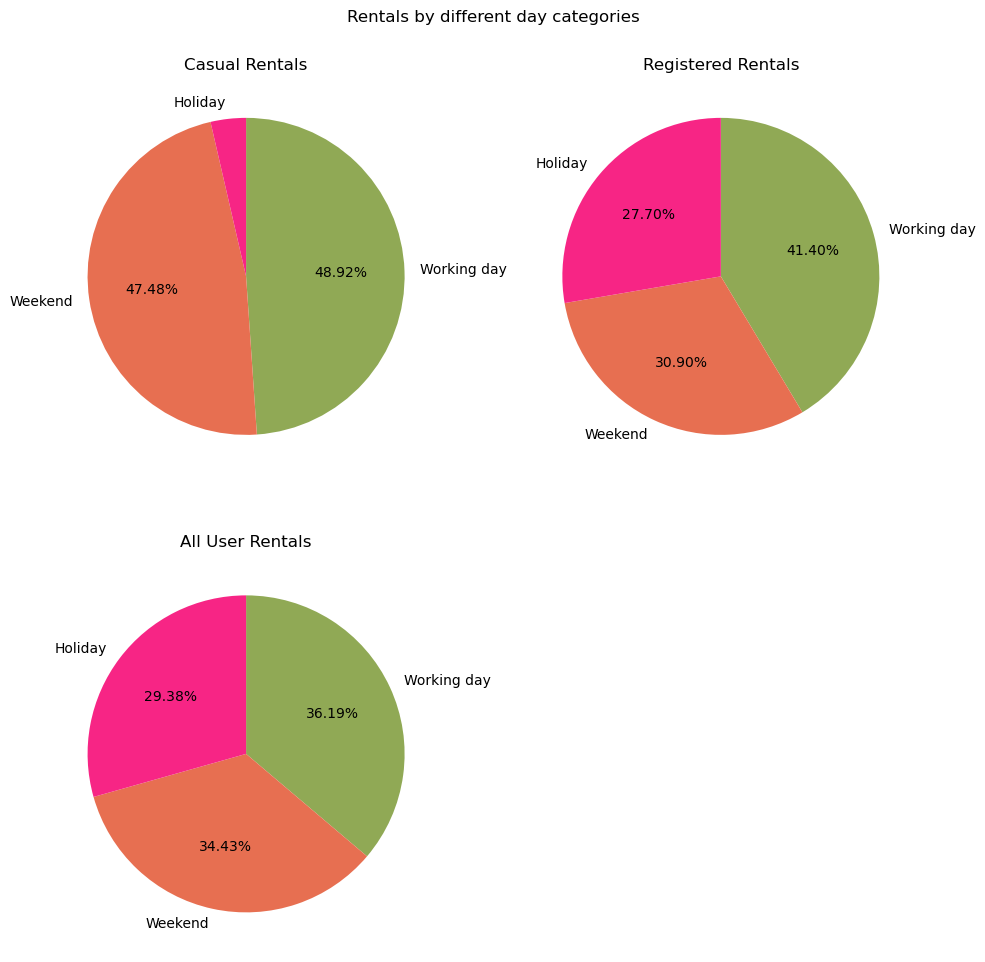

In [55]:
fig, axList = plt.subplots(2, 2, figsize = (10, 10))
axList = axList.flatten()
axList[len(axList) - 1].set_visible(False)

plt.suptitle("Rentals by different day categories")

plt.subplot(2, 2, 1)
Plot_PieCategory(mapped_df.groupby("day type")["casual"].sum().reindex(day_types), args = {
    "labels": day_types,
    "colors": ["#90A955", "#E76F51", "#F72585"],
    "title": "Casual Rentals"
})

plt.subplot(2, 2, 2)
Plot_PieCategory(mapped_df.groupby("day type")["registered"].mean().reindex(day_types), args = {
    "labels": day_types,
    "colors": ["#90A955", "#E76F51", "#F72585"],
    "title": "Registered Rentals"
})

plt.subplot(2, 2, 3)
Plot_PieCategory(mapped_df.groupby("day type")["count"].mean().reindex(day_types), args = {
    "labels": day_types,
    "colors": ["#90A955", "#E76F51", "#F72585"],
    "title": "All User Rentals"
})

plt.tight_layout()
plt.show()

Based on the different hours of different days (working day, weekend or holiday)
- Most of the profits comes from bikes being rented on a working day
- However, on average, the number of bikes rented per day is relatively similar

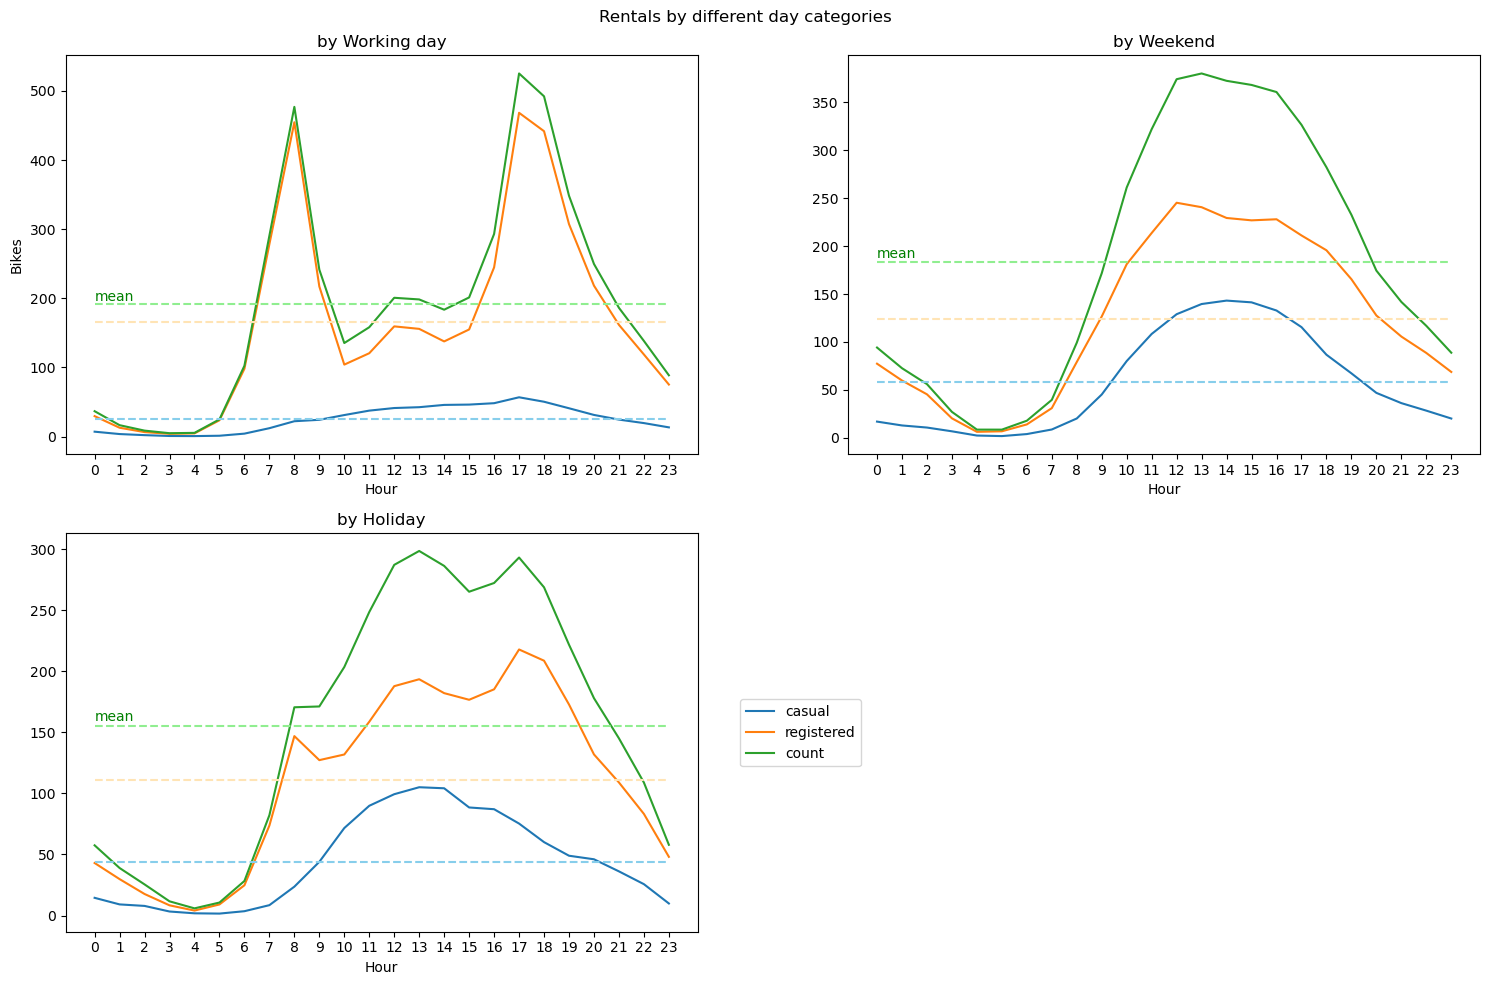

In [56]:
plt.figure(figsize = (15, 10))
plt.suptitle("Rentals by different day categories")

for ax_num, day_type in enumerate(day_types):
    day_type_df = mapped_df.loc[mapped_df["day type"] == day_type, :].groupby("hour").agg({"casual": "mean", "registered": "mean", "count": "mean"}).reindex(range(0, 24))
    day_type_mean_df = day_type_df.mean().astype(int)

    plt.subplot(2, 2, ax_num + 1)
    ax = Plot_TimeSeries(day_type_df, day_type_mean_df, args = {
        "title": f"by {day_type}",
        "xlabel": "Hour",
        "xticks": list(range(0, 24)),
        "ylabel": "Bikes",
        "bbox_to_anchor": (1.27, 0.6)
    })

    # Remove all y-axis labels except left-most plot
    if ax_num != 0:
        ax.set_ylabel("")

    # Only have one legend at the right-most plot
    if ax_num != len(day_types) - 1:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

Based on the different hours of different days (working day, weekend or holiday)
- The trend differs for each user on a different day
- For working day, it is similar to the previous line graph for total (INCLUDE line graph no. i.e. 13(a)), since most of the rented bikes are during a working day (include pie graph)
- There is a higher percentage of casual users renting bikes on weekends and holidays (blue mean is closer to orange mean), and they usually rent as time goes on

In Summary,
- Most bike rentals are by Registered users who use them for transportation to work and home
- Casual users usually rent bikes during the day for leisure and fun

#### Rentals by weather condition

In [57]:
weather_order

['Clear and cloudy',
 'Misty with varying clouds',
 'Light precipitation and thunder',
 'Intense storm with mixed precipitation']

In [58]:
weather_condition_df = mapped_df.groupby("weather").agg(casual = ("casual", "sum"), registered = ("registered", "sum"), count = ("count", "sum")).reindex(weather_order)

weather_colors = ["#87CEEB", "#4682B4", "#708090", "#2F4F4F"]

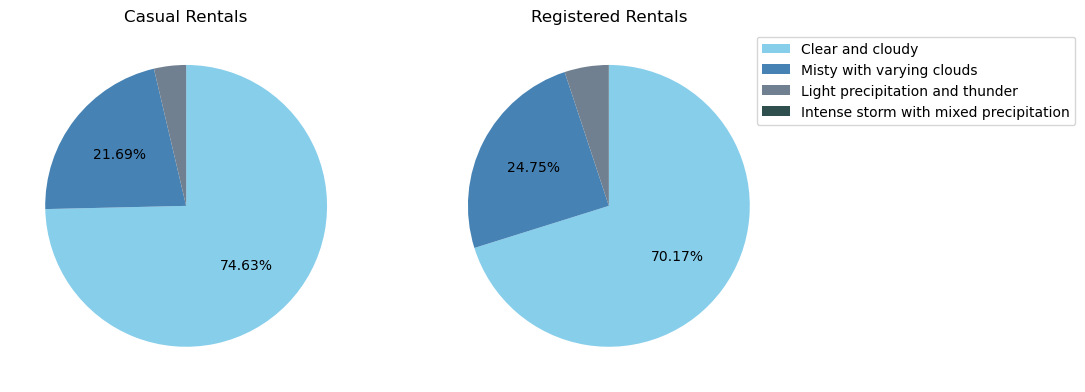

In [59]:
fig, axList = plt.subplots(1, 2, figsize = (10, 10))

plt.subplot(1, 2, 1)
Plot_PieCategory(weather_condition_df["casual"], args = {
    "colors": weather_colors,
    "title": "Casual Rentals",
})

plt.subplot(1, 2, 2)
Plot_PieCategory(weather_condition_df["registered"], args = {    
    "colors": weather_colors,
    "title": "Registered Rentals",
    "legend_labels": weather_order,
    "legend": True
})

plt.show()

#### Rentals by environments

Analysing the number of rentals based on the current weather environment

We will be focusing on temp, humidity and wind speed. Apparent temp will not be analysed since it is a combination of the other weather features.

In [60]:
weather_cols = ["temp", "humidity", "wind speed"]

##### Univariate

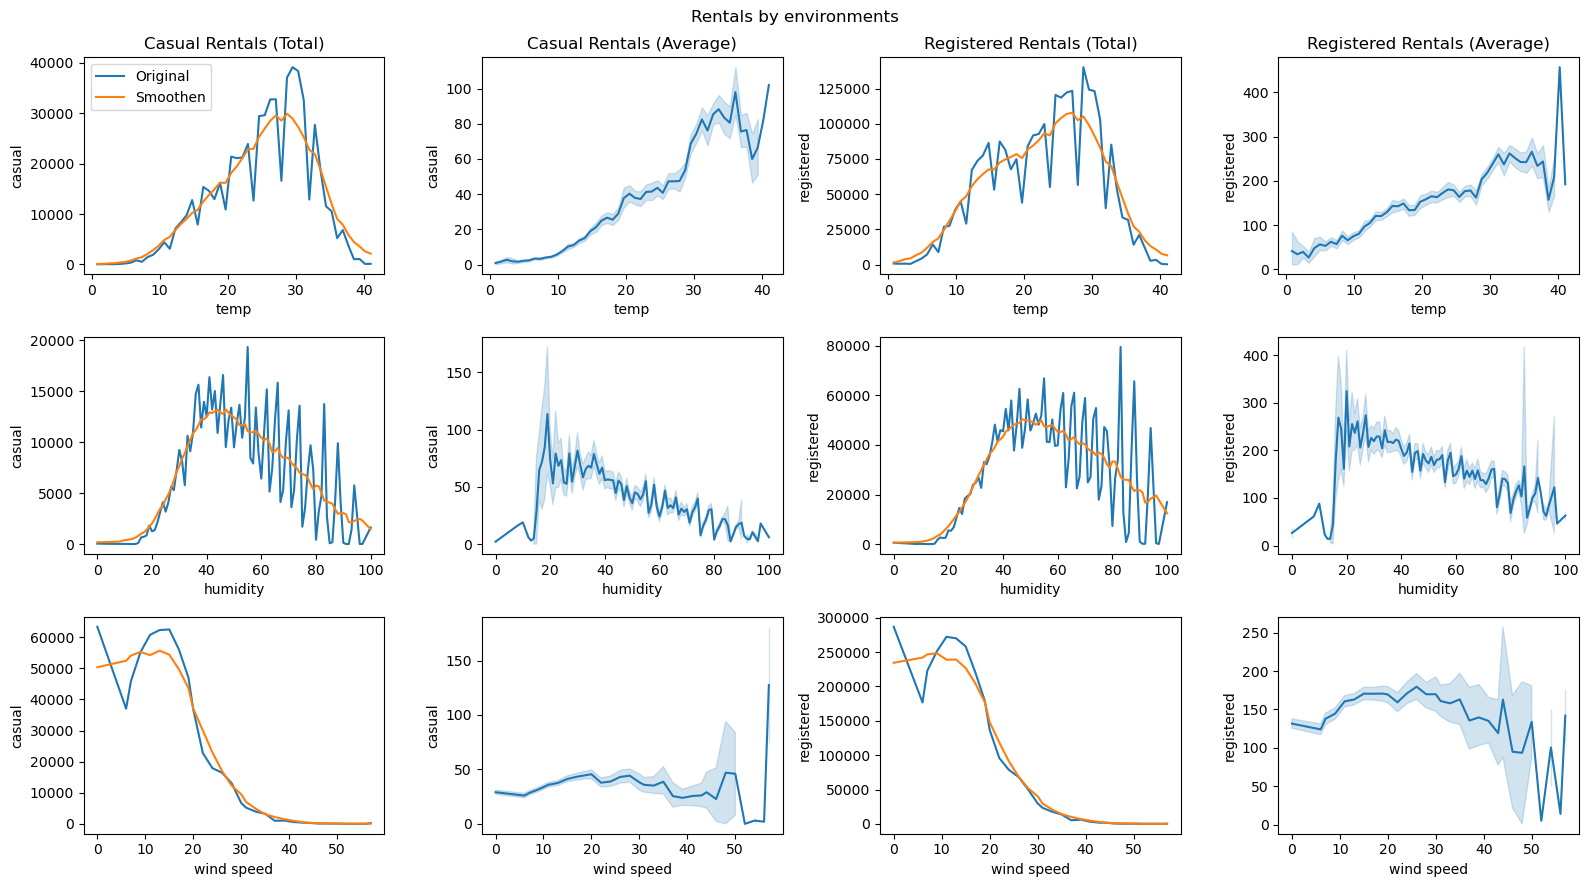

In [61]:
fig, axList = plt.subplots(3, 4, figsize = (16, 9))
fig.suptitle("Rentals by environments")
axList = axList.reshape(3, -1)

for i, (axRow, col) in enumerate(zip(axList, weather_cols)):
    weather_df = mapped_df.groupby(col).agg({"casual": "sum", "registered": "sum"})

    # To smoothen plot, window taking 20% of total indexes
    window_size = int(weather_df.shape[0] * 0.2)
    y_cas_smooth = centered_moving_average(weather_df["casual"].values, window_size)
    y_reg_smooth = centered_moving_average(weather_df["registered"].values, window_size)
    
    sns.lineplot(data = weather_df, x = col, y = "casual", label = "Original", ax = axRow[0])    
    sns.lineplot(x = weather_df.index, y = y_cas_smooth, label = "Smoothen", ax = axRow[0])
    
    sns.lineplot(data = mapped_df, x = col, y = "casual", ax = axRow[1])

    sns.lineplot(data = weather_df, x = col, y = "registered", label = "Original", ax = axRow[2])
    sns.lineplot(x = weather_df.index, y = y_reg_smooth, label = "Smoothen", ax = axRow[2])

    sns.lineplot(data = mapped_df, x = col, y = "registered", ax = axRow[3])

    if i == 0:
        axRow[0].set_title("Casual Rentals (Total)")
        axRow[1].set_title("Casual Rentals (Average)")
        axRow[2].set_title("Registered Rentals (Total)")
        axRow[3].set_title("Registered Rentals (Average)")
        
        axRow[2].get_legend().remove()
    else:
        axRow[0].get_legend().remove()
        axRow[2].get_legend().remove()

plt.tight_layout()
plt.show()

Based on the weather environments through univariate analysis
- The peak weather condition for bike rentals are about 25 - 35 temp, 30 - 50 humidity and 10 - 20 wind speed
- There is a similar trend for casual and registered rentals with humidity and wind speed, but most casual rentals have slightly higher temperatures than registered rentals
- Casual users have more freedom on when they want to ride a bike, while registered users have to ride a bike as means for a substitute for transportation

##### Bivariate

Trying out bivariate analysis, to see if there is a trend for different weather patterns

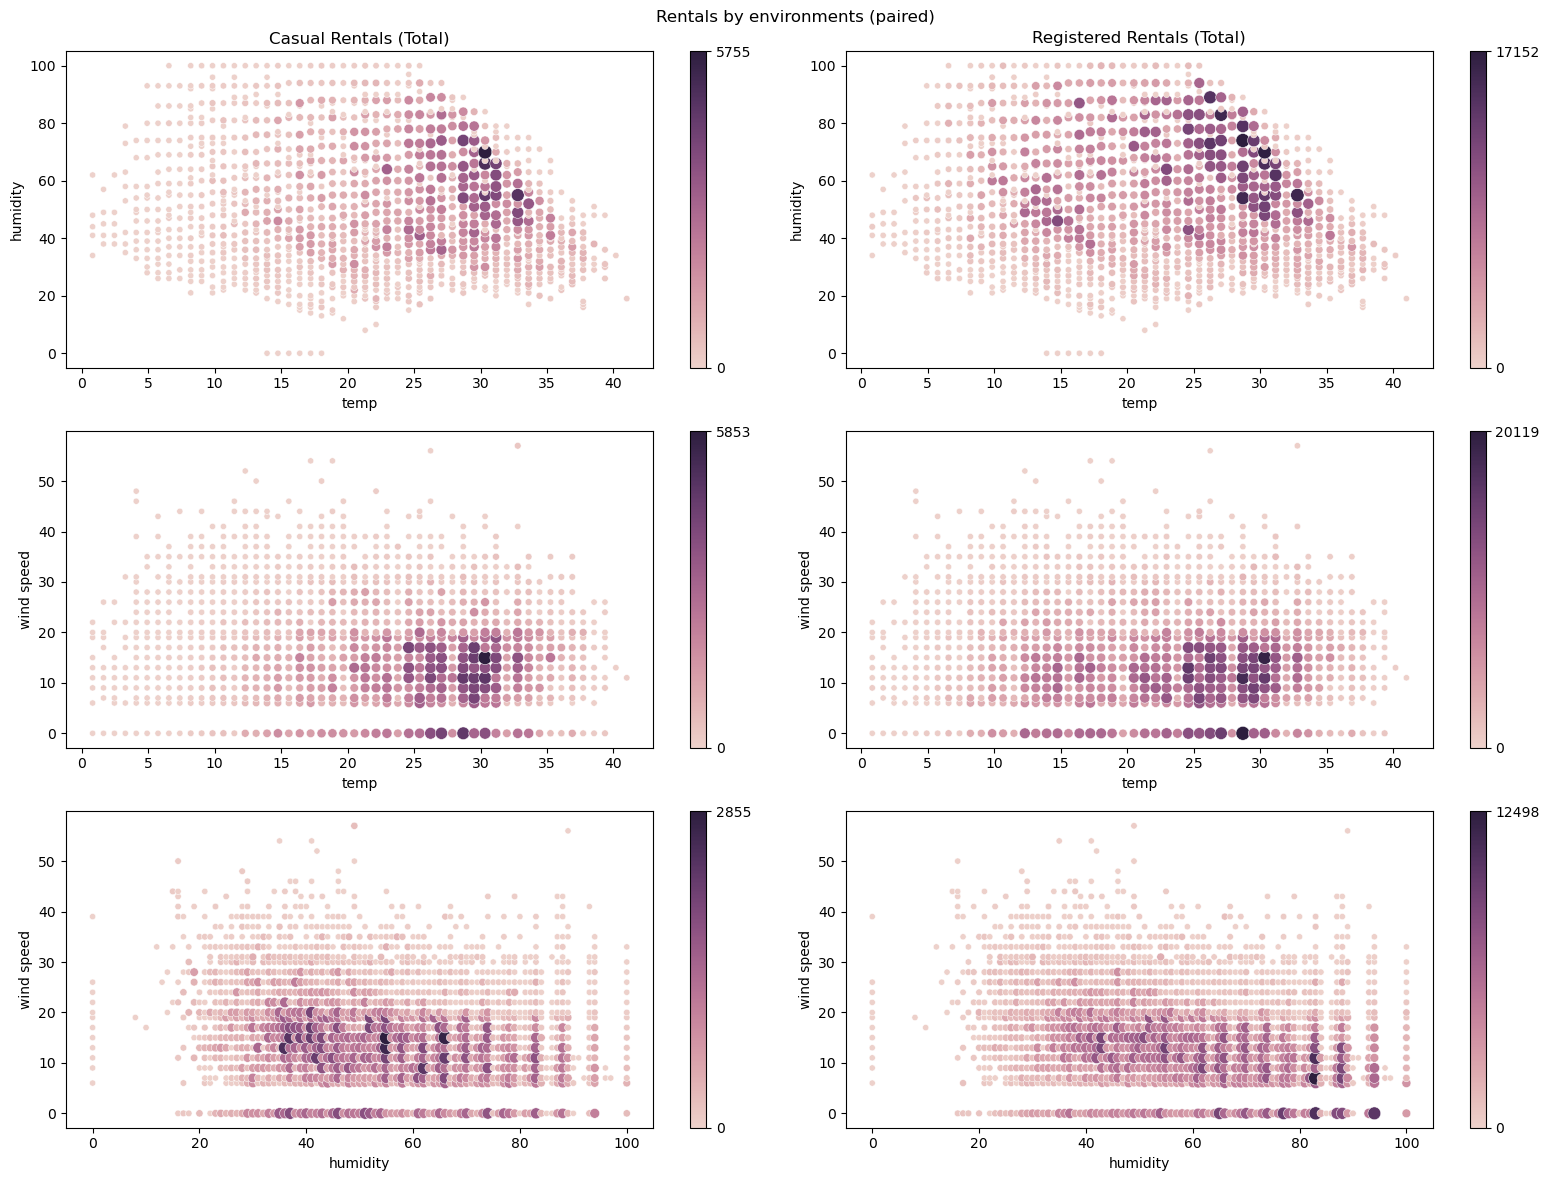

In [62]:
paired_weather_cols = [(weather_cols[i], weather_cols[j])for i in range(len(weather_cols)) for j in range(i + 1, len(weather_cols))]

fig, axList = plt.subplots(3, 2, figsize = (16, 12))
fig.suptitle("Rentals by environments (paired)")
axList = axList.reshape(3, -1)

for i, (axRow, paired_weather) in enumerate(zip(axList, paired_weather_cols)):
    w0, w1 = paired_weather[0], paired_weather[1]
    
    weather_df = mapped_df.groupby([w0, w1]).agg({"casual": "sum", "registered": "sum"}).reset_index()

    palette = sns.cubehelix_palette(as_cmap = True)
    
    sns.scatterplot(weather_df, x = w0, y = w1, hue = "casual", palette = palette,
                        size = "casual", sizes = (20, 100), legend = False, ax = axRow[0])

    norm = plt.Normalize(0, weather_df["casual"].max())
    sm = plt.cm.ScalarMappable(cmap = palette, norm = norm)

    ax.figure.colorbar(sm, ax = axRow[0], ticks = [0, weather_df["casual"].max()])

    ax.set_title(f"Total Rentals by {w0} and {w1}")

    sns.scatterplot(weather_df, x = w0, y = w1, hue = "registered", palette = palette,
                        size = "registered", sizes = (20, 100), legend = False, ax = axRow[1])

    norm = plt.Normalize(0, weather_df["registered"].max())
    sm = plt.cm.ScalarMappable(cmap = palette, norm = norm)

    ax.figure.colorbar(sm, ax = axRow[1], ticks = [0, weather_df["registered"].max()])

    ax.set_title(f"Total Rentals by {w0} and {w1}")

    if i == 0:
        axRow[0].set_title("Casual Rentals (Total)")
        axRow[1].set_title("Registered Rentals (Total)")
    
plt.tight_layout()
plt.show()

Based on the weather environments through bivariate analysis
- Looking at temp with humidity and wind speed separately, there is a bigger spread of temp registered rentals than casual rentals
- wind speed and humidity shows similar plots for both registered and casual rentals
- The gap between the graphs comes from wind speed = 0. It is assumed that wind speed can be 0, although it might feel inconsistent with the gap it has to the next lowest wind speed

##### Multivariate (All 3 weather features)

Multivariate analysis<br>

You can adjust how clear you want the scatter plot to be with `COUNT_STOP`.<br>
As the value increases, the data becomes less scattered, resulting in a clearer and less cluttered scatterplot.<br>
You can also decrease the value, if you want a more accurate result.

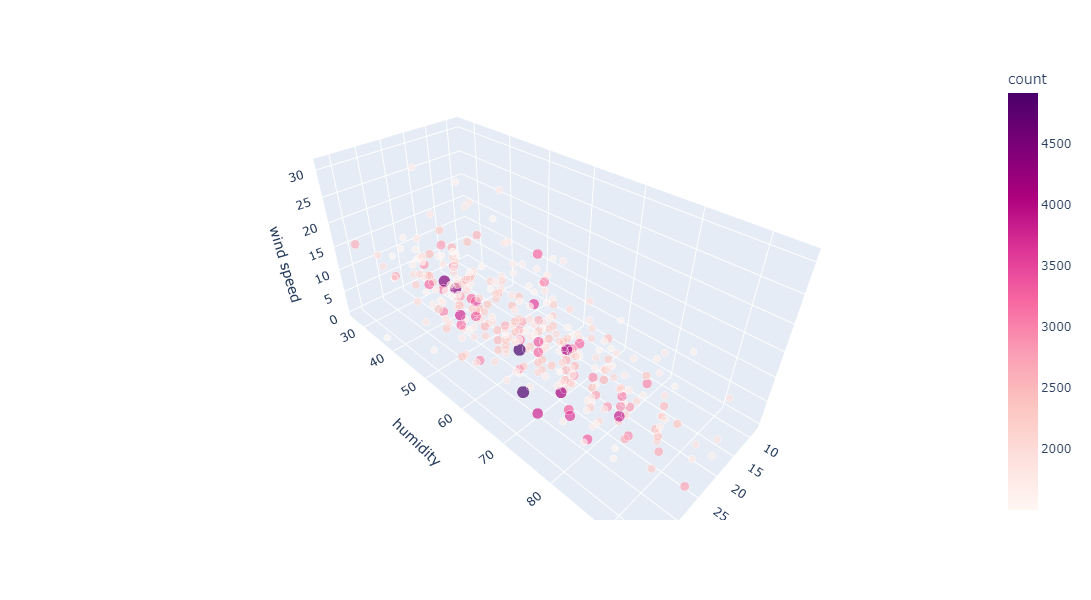

In [63]:
COUNT_STOP = 1500

weather_df = mapped_df.groupby(weather_cols).agg({"count": "sum"}).reset_index()

fig = px.scatter_3d(weather_df.loc[weather_df["count"] > COUNT_STOP, :], x = "temp", y = "humidity", z = "wind speed", color = "count", color_continuous_scale = "RdPu", size = "count")

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
)
fig.show()

Based on the weather environments through multivariate analysis
- Most rentals are within 20 - 30 temp, 30 - 80 humidity and 10 - 20 wind speed

### <a id = "model">Data Modelling</a>

In this project, we will be also training a model to fix missing data.

As we filled up our missing datetime data earlier, only the number of rented bikes (i.e. casual and registered) is not filled. These values will be filled by using the cleaned data as our training and validation set to train a model, and ultimately predict the number of rented bikes in a given day.

- Indepedent Variables:
    - Day variables: season, year, month
    - Weather variables, day type, hour, temp, humidity, wind speed<br>
    Note: atemp will be dropped because it is a calculated value from temp, humidity and wind speed
- Dependent Variables: casual, registered
Note: count will not be trained as it can be computed by summing casual and registered

We will be experimenting with Random Forest models

#### Training model

Performing one hot encoding by remapping labels to number values

In [64]:
season_ohe_cols = [f"is_{season}" for season in season_order]
season_ohe_df = pd.get_dummies(mapped_df["season"], prefix = "is")[season_ohe_cols]

year_ohe_cols = [f"is_{year}" for year in year_order]
year_ohe_df = pd.get_dummies(mapped_df["year"], prefix = "is")[year_ohe_cols]

month_ohe_cols = [f"is_{month}" for month in month_order]
month_ohe_df = pd.get_dummies(mapped_df["month"], prefix = "is")[month_ohe_cols]

weather_ohe_cols = [f"is_{weather}" for weather in weather_order]
weather_ohe_df = pd.get_dummies(mapped_df["weather"], prefix = "is")[weather_ohe_cols]

daytype_ohe_cols = [f"is_{day_type}" for day_type in day_types]
daytype_ohe_df = pd.get_dummies(mapped_df["day type"], prefix = "is")[daytype_ohe_cols]

x_df = mapped_df.loc[:, ["hour", "temp", "humidity", "wind speed"]]
x_df = pd.concat([season_ohe_df, year_ohe_df, month_ohe_df, daytype_ohe_df, weather_ohe_df, x_df], axis = 1)

y_casual_df = mapped_df.loc[:, "casual"]
y_registered_df = mapped_df.loc[:, "registered"]

In [65]:
display(x_df.head())
display(y_casual_df.head())
display(y_registered_df.head())

is_Spring  is_Summer  is_Fall  is_Winter  is_2011  is_2012  is_Jan  is_Feb  \
0       True      False    False      False     True    False    True   False   
1       True      False    False      False     True    False    True   False   
2       True      False    False      False     True    False    True   False   
3       True      False    False      False     True    False    True   False   
4       True      False    False      False     True    False    True   False   

   is_Mar  is_Apr  ...  is_Weekend  is_Holiday  is_Clear and cloudy  \
0   False   False  ...        True       False                 True   
1   False   False  ...        True       False                 True   
2   False   False  ...        True       False                 True   
3   False   False  ...        True       False                 True   
4   False   False  ...        True       False                 True   

   is_Misty with varying clouds  is_Light precipitation and thunder  \
0                         False                               False   
1                         False                               False   
2                         False                               False   
3                         False                               False   
4                         False                               False   

   is_Intense storm with mixed precipitation  hour  temp  humidity  wind speed  
0                                      False     0  9.84      81.0         0.0  
1                                      False     1  9.02      80.0         0.0  
2                                      False     2  9.02      80.0         0.0  
3                                      False     3  9.84      75.0         0.0  
4                                      False     4  9.84      75.0         0.0  

[5 rows x 29 columns]

0    3
1    8
2    5
3    3
4    0
Name: casual, dtype: int64

0    13
1    32
2    27
3    10
4     1
Name: registered, dtype: int64

We have a total of 29 features.
- Season (4 features)
- Year (2 features)
- Month (12 features)
- Day Type (3 features)
- Weather Category (4 features)
- hour, tmep, humidity and wind speed (4 features)

For tree models, scaling the dataset is not a concern as they split the data based on individual features, not through linear/non-linear relationships between features

In [66]:
x_train, x_test, y_cas_train, y_cas_test, y_reg_train, y_reg_test = train_test_split(x_df, y_casual_df, y_registered_df, test_size = 0.2, random_state = 42)

We will be building a simple pipeline and using a brute force method to train a small set of hyperparameters

In [67]:
pipeline = Pipeline([
    ("rfr", RandomForestRegressor(random_state = 42))
])

param_grid = {
    "rfr__n_estimators": [100, 200, 300],
    "rfr__max_depth": [5, 10, 20],
    "rfr__min_samples_split": [2, 5, 10],
    "rfr__min_samples_leaf": [1, 2, 5, 10]
}

In [68]:
print("Run Casual Model: ")
grid_search_cas = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5, scoring = "neg_mean_squared_error", verbose = 2)

grid_search_cas.fit(x_train, y_cas_train)

print("Run Registered Model: ")
grid_search_reg = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = 5, scoring = "neg_mean_squared_error", verbose = 2)

grid_search_reg.fit(x_train, y_reg_train)

Run Casual Model: 
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, rfr__n_estimators=100; total time=   1.1s
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, rfr__n_estimators=100; total time=   0.9s
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, rfr__n_estimators=100; total time=   0.9s
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, rfr__n_estimators=100; total time=   1.0s
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, rfr__n_estimators=100; total time=   1.0s
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, rfr__n_estimators=200; total time=   2.1s
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, rfr__n_estimators=200; total time=   2.0s
[CV] END rfr__max_depth=5, rfr__min_samples_leaf=1, rfr__min_samples_split=2, 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfr',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'rfr__max_depth': [5, 10, 20],
                         'rfr__min_samples_leaf': [1, 2, 5, 10],
                         'rfr__min_samples_split': [2, 5, 10],
                         'rfr__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [69]:
print("Best Model for Casual: ")
print(grid_search_cas.best_params_)
print(f"MSE: {grid_search_cas.best_score_}")

print()

print("Best Model for Registered: ")
print(grid_search_reg.best_params_)
print(f"MSE: {grid_search_reg.best_score_}")

Best Model for Casual: 
{'rfr__max_depth': 20, 'rfr__min_samples_leaf': 1, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 200}
MSE: -257.2966173093707

Best Model for Registered: 
{'rfr__max_depth': 20, 'rfr__min_samples_leaf': 2, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 300}
MSE: -1504.0989780289806


In [70]:
cas_rf_model = grid_search_cas.best_estimator_
reg_rf_model = grid_search_reg.best_estimator_

In [71]:
y_cas_pred = np.round(cas_rf_model.predict(x_test)).astype(int)
y_reg_pred = np.round(reg_rf_model.predict(x_test)).astype(int)

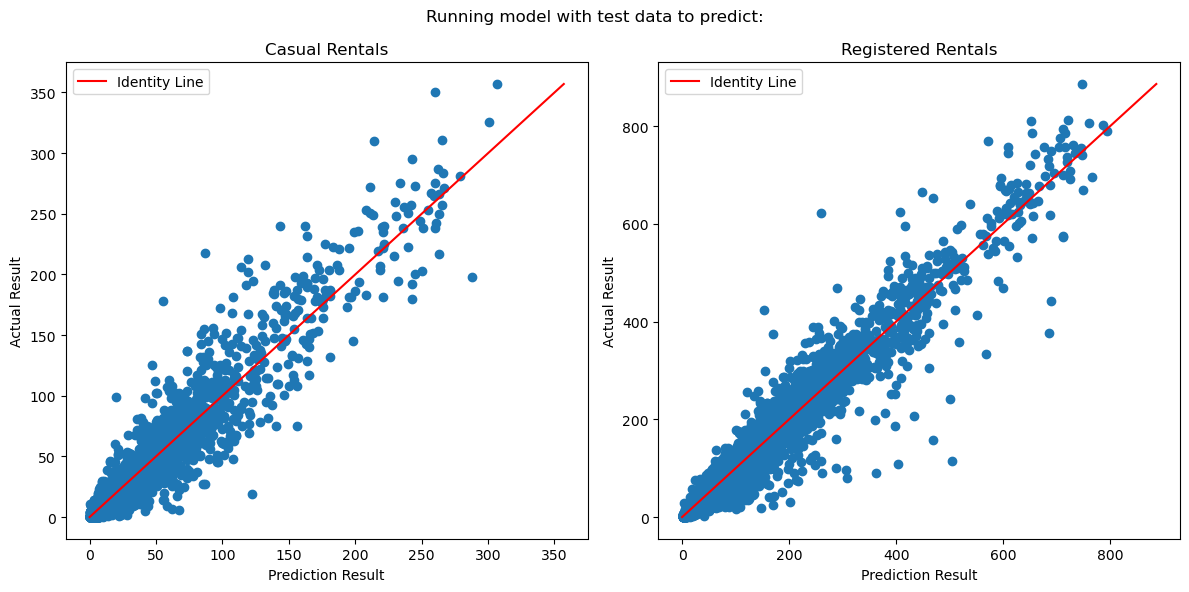

Casual: 
Mean Squared Error: 220.118527
Accuracy (as percentage): 90.42%

Registered: 
Mean Squared Error: 1463.913119
Accuracy (as percentage): 93.37%


In [72]:
plt.subplots(1, 2, figsize = (12, 6))
plt.suptitle("Running model with test data to predict:")

plt.subplot(1, 2, 1)
Plot_Model_Result(y_cas_pred, y_cas_test, title = "Casual Rentals")

plt.subplot(1, 2, 2)
Plot_Model_Result(y_reg_pred, y_reg_test, title = "Registered Rentals")

plt.tight_layout()
plt.show()

print("Casual: ")
Display_Calculated_Accuracy(y_cas_pred, y_cas_test)
print()
print("Registered: ")
Display_Calculated_Accuracy(y_reg_pred, y_reg_test)

Both models have over 90% accuracy. However, as the model have shown some inaccuracies in identifying less encountered data.

#### Filling up missing values

With the trained model, we are now able to fill up the missing values.
- Identify the missing datetimes with missing_df
- Run the missing datetimes and their feature values seen in missing_df with the 2 models to fill both casual and registered
- Merge the results from casual and registered back to the original dataframe and calculate the sum to return count

In [73]:
pre_proc_missing_df = PreProcessing_Missing_df(missing_df, x_df.columns)
pre_proc_missing_df.head()

is_Spring  is_Summer  is_Fall  is_Winter  is_2011  is_2012  is_Jan  is_Feb  \
0       True      False    False      False     True    False    True   False   
1       True      False    False      False     True    False    True   False   
2       True      False    False      False     True    False    True   False   
3       True      False    False      False     True    False    True   False   
4       True      False    False      False     True    False    True   False   

   is_Mar  is_Apr  ...  is_Weekend  is_Holiday  is_Clear and cloudy  \
0   False   False  ...        True       False                False   
1   False   False  ...       False       False                 True   
2   False   False  ...       False       False                 True   
3   False   False  ...       False       False                 True   
4   False   False  ...       False       False                 True   

   is_Misty with varying clouds  is_Light precipitation and thunder  \
0                          True                               False   
1                         False                               False   
2                         False                               False   
3                         False                               False   
4                         False                               False   

   is_Intense storm with mixed precipitation  hour   temp  humidity  \
0                                      False     5  18.04      86.0   
1                                      False     2   7.79      45.0   
2                                      False     3   6.97      46.0   
3                                      False     3   5.74      63.0   
4                                      False     3   8.20      61.0   

   wind speed  
0     16.4954  
1     27.3360  
2     26.6660  
3      7.5040  
4     10.5056  

[5 rows x 29 columns]

In [74]:
cas_result = np.round(cas_rf_model.predict(pre_proc_missing_df)).astype(int)
reg_result = np.round(reg_rf_model.predict(pre_proc_missing_df)).astype(int)

In [77]:
missing_df["casual"] = cas_result
missing_df["registered"] = reg_result
missing_df["count"] = missing_df["casual"] + missing_df["registered"]

In [78]:
missing_df.head()

datetime        date season  year month hour weekday working day  \
0 2011-01-02 05:00:00  2011-01-02      1  2011     1    5       0           0   
1 2011-01-03 02:00:00  2011-01-03      1  2011     1    2       1           1   
2 2011-01-03 03:00:00  2011-01-03      1  2011     1    3       1           1   
3 2011-01-04 03:00:00  2011-01-04      1  2011     1    3       2           1   
4 2011-01-05 03:00:00  2011-01-05      1  2011     1    3       3           1   

  holiday weather  temp   atemp  humidity  wind speed  casual  registered  \
0       0       2  0.44  0.4394      0.86      0.2462       1           3   
1       0       1  0.19  0.1566      0.45      0.4080       0           2   
2       0       1  0.17  0.1465      0.46      0.3980       0           1   
3       0       1  0.14  0.1666      0.63      0.1120       0           2   
4       0       1  0.20  0.2122      0.61      0.1568       0           2   

   count  
0      4  
1      2  
2      1  
3      2  
4      2

### <a id = "conclusion">Conclusion</a>

In this project, we analysed the rental numbers from both casual and registered users. While there are similarities in the rental trend, there are also noticable differences between the two groups.

Regarding different time periods, we noticed that most bike rentals occur during the summer and fall, though this might vary in reality. Registered users frequently ride during peak weekday hours, assumably as mode of transporation to and fro work. On the other hand, casual users given more flexibility, prefer leisure rides during afternoons and on weekends.

Weather conditions significantly influence casual users rental patterns as they tend to rent bikes when the weather is clear or mildly misty, with low or no chance of rain. Conversely, rentals by registered users are less likely affected by weather, as they primarily rent bikes for communting to places.

Based on our analysis, we can offer some suggestions to improve the number of bike rentals
<ul>
    <li>Increase the number of bikes available during peak periods and favourable weather conditions</li>
    <ul>
        <li>To meet the demand from users, we should ensure a sufficient supply of bikes, particularly during peak time periods and in popular areas, likely around the city centery(although our dataset does not specify exact locations)</li>
    </ul>
    <li>Offer incentives or benefits to registered users</li>
    <ul>
        <li>We can introduce promotions or discounts for registered users. For example, an interal points system could reward users with points for each ride, which they can redeem for discounted or free future rentals</li>
        <li>Since most rentals come from registered users, providing more incentivies for them could not only increase rentals but also attract casual users to register. In this way, they can enjoy exclusive features and promotions available only to registered users</li>
    </ul>
</ul>

Lastly, we identified missing datetimes in the dataset and trained a Random Forest model that estimates the number of bike rentals with over 90% accuracy.

#### Ways to further improve

- Analyse wind speed = 0, maybe remove them or fill in missing values. Since it might be inconsistent and will affect training of model
- Try out different models other than Tree models (e.g. Multi-variate Regression models)